### Deep Learning

In [1]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
import nltk
import unidecode
import re
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import RMSprop
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout, GlobalMaxPooling1D
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
def load_dataset(filename):
    df = pd.read_csv(filename)
    print(df.head())
    intent = df["intent"]
    unique_intent = list(set(intent))
    sentences = list(df["sentence"])
  
    return (intent, unique_intent, sentences)

In [3]:
intent, unique_intent, sentences = load_dataset("ChatbotCorpus.csv")

                                            sentence          intent
0                           i want to go marienplatz  FindConnection
1        when is the next train in muncher freiheit?   DepartureTime
2  when does the next u-bahn leaves from garching...   DepartureTime
3       from olympia einkaufszentrum to hauptbahnhof  FindConnection
4  when is the next train from winterstraße 12 to...  FindConnection


In [4]:
print(*sentences[:40], sep = "\n")

i want to go marienplatz
when is the next train in muncher freiheit?
when does the next u-bahn leaves from garching forschungszentrum?
from olympia einkaufszentrum to hauptbahnhof
when is the next train from winterstraße 12 to kieferngarten
when is the next rocket from winterstraße 12 to kieferngarte
can you find a connection from garching to hauptbahnhof?
how to get from untere strassäcker 21 to fröttmaning
how i can get from marienplatz to garching
connection from boltzmannstraße to kieferngarten
how to get from bonner platz to freimann?
when is the next s-bahn leaving at garching?
how do i get from oez to hbf?
how to get from winterstrasse 12 to fröttmaning
how do i get from garching forschungszentrum to pasing
theresienstraße to assling
how can i get from theresienstraße to munich east?
when does the next bus starts from garching?
from quiddestraße to garching?
can you find a connection from kurt-eisner-straße to garching forschungszentrum?
can you find a connection from quiddestra

In [5]:
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shadow\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shadow\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
stemmer = LancasterStemmer()

In [7]:
def cleaning(sentences):
    words = []
    for s in sentences:
        clean = re.sub(r'[^ a-z A-Z 0-9]', " ", s)
        w = word_tokenize(clean)
        #stemming
        words.append([i.lower() for i in w])
    
    return words

In [8]:
cleaned_words = cleaning(sentences)

In [9]:
cleaned_words

[['i', 'want', 'to', 'go', 'marienplatz'],
 ['when', 'is', 'the', 'next', 'train', 'in', 'muncher', 'freiheit'],
 ['when',
  'does',
  'the',
  'next',
  'u',
  'bahn',
  'leaves',
  'from',
  'garching',
  'forschungszentrum'],
 ['from', 'olympia', 'einkaufszentrum', 'to', 'hauptbahnhof'],
 ['when',
  'is',
  'the',
  'next',
  'train',
  'from',
  'winterstra',
  'e',
  '12',
  'to',
  'kieferngarten'],
 ['when',
  'is',
  'the',
  'next',
  'rocket',
  'from',
  'winterstra',
  'e',
  '12',
  'to',
  'kieferngarte'],
 ['can',
  'you',
  'find',
  'a',
  'connection',
  'from',
  'garching',
  'to',
  'hauptbahnhof'],
 ['how',
  'to',
  'get',
  'from',
  'untere',
  'strass',
  'cker',
  '21',
  'to',
  'fr',
  'ttmaning'],
 ['how', 'i', 'can', 'get', 'from', 'marienplatz', 'to', 'garching'],
 ['connection', 'from', 'boltzmannstra', 'e', 'to', 'kieferngarten'],
 ['how', 'to', 'get', 'from', 'bonner', 'platz', 'to', 'freimann'],
 ['when', 'is', 'the', 'next', 's', 'bahn', 'leaving', 

In [10]:
cleaned_words = cleaning(sentences)
print(len(cleaned_words))
print(cleaned_words[:3])

206
[['i', 'want', 'to', 'go', 'marienplatz'], ['when', 'is', 'the', 'next', 'train', 'in', 'muncher', 'freiheit'], ['when', 'does', 'the', 'next', 'u', 'bahn', 'leaves', 'from', 'garching', 'forschungszentrum']]


In [11]:
def create_tokenizer(words, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'):
    token = Tokenizer(filters = filters)
    token.fit_on_texts(words)
    return token

In [12]:
def max_length(words):
    return(len(max(words, key = len)))

In [13]:
word_tokenizer = create_tokenizer(cleaned_words)
vocab_size = len(word_tokenizer.word_index) + 1
max_length = max_length(cleaned_words)

print("Vocab Size = %d and Maximum length = %d" % (vocab_size, max_length))

Vocab Size = 182 and Maximum length = 17


In [14]:
def encoding_doc(token, words):
    return(token.texts_to_sequences(words))

In [15]:
encoded_doc = encoding_doc(word_tokenizer, cleaned_words)

In [16]:
def padding_doc(encoded_doc, max_length):
    return(pad_sequences(encoded_doc, maxlen = max_length, padding = "post"))

In [17]:
padded_doc = padding_doc(encoded_doc, max_length)

In [18]:
print("Shape of padded docs = ",padded_doc.shape)

Shape of padded docs =  (206, 17)


In [19]:
output_tokenizer = create_tokenizer(unique_intent, filters = '!"#$%&()*+,-/:;<=>?@[\]^`{|}~')

In [20]:
output_tokenizer.word_index

{'departuretime': 1, 'findconnection': 2}

In [21]:
encoded_output = encoding_doc(output_tokenizer, intent)

In [22]:
encoded_output = np.array(encoded_output).reshape(len(encoded_output), 1)

In [23]:
encoded_output.shape

(206, 1)

In [24]:
def one_hot(encode):
    
#     label_encoder = preprocessing.LabelEncoder() 
#     return label_encoder.fit_transform(encode) 
    
    o = OneHotEncoder(sparse = False)
    return(o.fit_transform(encode))

In [25]:
output_one_hot = one_hot(encoded_output)

C:\Users\shadow\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [26]:
from sklearn.model_selection import train_test_split

In [27]:
train_X, val_X, train_Y, val_Y = train_test_split(padded_doc, output_one_hot, shuffle = True, test_size = 0.2)

In [28]:
print("Shape of train_X = %s and train_Y = %s" % (train_X.shape, train_Y.shape))
print("Shape of val_X = %s and val_Y = %s" % (val_X.shape, val_Y.shape))

Shape of train_X = (164, 17) and train_Y = (164, 2)
Shape of val_X = (42, 17) and val_Y = (42, 2)


In [29]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [30]:
def create_model(vocab_size, max_length):
    model = Sequential()
    model.add(Embedding(vocab_size, 128, input_length = max_length, trainable = False))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dense(16, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = "sigmoid"))
  
    return model

In [31]:
model = create_model(vocab_size, max_length)

model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.summary()

W0102 08:34:23.511785 21572 deprecation_wrapper.py:119] From C:\Users\shadow\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0102 08:34:23.573618 21572 deprecation_wrapper.py:119] From C:\Users\shadow\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0102 08:34:23.592568 21572 deprecation_wrapper.py:119] From C:\Users\shadow\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0102 08:34:24.268377 21572 deprecation_wrapper.py:119] From C:\Users\shadow\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:148: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0102 08:34:24.281343 21572 deprecation.py

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 17, 128)           23296     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                4112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 34        
Total params: 290,610
Trainable params: 267,314
Non-trainable params: 23,296
_________________________________________________________________


In [32]:
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

hist = model.fit(train_X, train_Y, epochs = 50, batch_size = 32, validation_data = (val_X, val_Y), callbacks = [checkpoint])

Train on 164 samples, validate on 42 samples
Epoch 1/50
164/164 [==============================] - 3s 17ms/step - loss: 0.6871 - acc: 0.5244 - val_loss: 0.6795 - val_acc: 0.5952

Epoch 00001: val_loss improved from inf to 0.67949, saving model to model.h5
Epoch 2/50
164/164 [==============================] - 0s 821us/step - loss: 0.6767 - acc: 0.5762 - val_loss: 0.6640 - val_acc: 0.5952

Epoch 00002: val_loss improved from 0.67949 to 0.66404, saving model to model.h5
Epoch 3/50
164/164 [==============================] - 0s 1ms/step - loss: 0.6598 - acc: 0.5915 - val_loss: 0.6534 - val_acc: 0.5952

Epoch 00003: val_loss improved from 0.66404 to 0.65338, saving model to model.h5
Epoch 4/50
164/164 [==============================] - 0s 1ms/step - loss: 0.6487 - acc: 0.5793 - val_loss: 0.6337 - val_acc: 0.5952

Epoch 00004: val_loss improved from 0.65338 to 0.63367, saving model to model.h5
Epoch 5/50
164/164 [==============================] - 0s 1ms/step - loss: 0.6315 - acc: 0.5854 - val

Epoch 41/50
164/164 [==============================] - 0s 1ms/step - loss: 0.1017 - acc: 0.9451 - val_loss: 0.0013 - val_acc: 1.0000

Epoch 00041: val_loss did not improve from 0.00105
Epoch 42/50
164/164 [==============================] - 0s 851us/step - loss: 0.0358 - acc: 0.9878 - val_loss: 0.4243 - val_acc: 0.9286

Epoch 00042: val_loss did not improve from 0.00105
Epoch 43/50
164/164 [==============================] - 0s 821us/step - loss: 0.2054 - acc: 0.9360 - val_loss: 0.3498 - val_acc: 0.9286

Epoch 00043: val_loss did not improve from 0.00105
Epoch 44/50
164/164 [==============================] - 0s 918us/step - loss: 0.1294 - acc: 0.9726 - val_loss: 0.0021 - val_acc: 1.0000

Epoch 00044: val_loss did not improve from 0.00105
Epoch 45/50
164/164 [==============================] - 0s 784us/step - loss: 0.0945 - acc: 0.9695 - val_loss: 0.0035 - val_acc: 1.0000

Epoch 00045: val_loss did not improve from 0.00105
Epoch 46/50
164/164 [==============================] - 0s 827us/ste

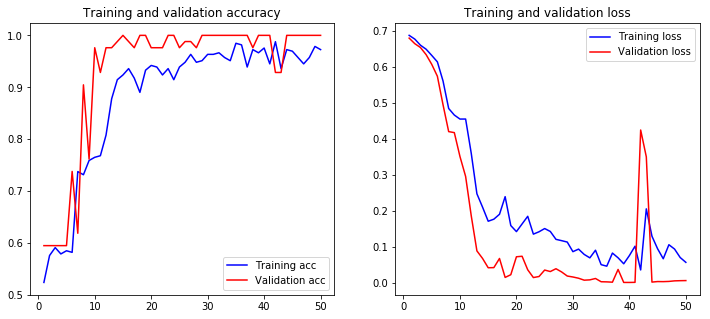

In [33]:
plot_history(hist)

In [34]:
model = load_model("model.h5")

In [35]:
scores = model.evaluate(val_X, val_Y, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 100.00%


In [36]:
def predictions(text):
    clean = re.sub(r'[^ a-z A-Z 0-9]', " ", text)
    test_word = word_tokenize(clean)
    test_word = [w.lower() for w in test_word]
    test_ls = word_tokenizer.texts_to_sequences(test_word)
    
    #Check for unknown words
    if [] in test_ls:
        test_ls = list(filter(None, test_ls))
    
    test_ls = np.array(test_ls).reshape(1, len(test_ls))
 
    x = padding_doc(test_ls, max_length)
  
    pred = model.predict_proba(x)
    return pred

In [37]:
def get_final_output(pred, classes):
    predictions = pred[0]
    classes = np.array(classes)
    ids = np.argsort(-predictions)
    classes = classes[ids]
    predictions = -np.sort(-predictions)
    for i in range(pred.shape[1]):
        print("%s has confidence = %s" %(classes[i], (predictions[i])))

In [38]:
text = "when does next u-bahn leave from garching"
pred = predictions(text)
get_final_output(pred, unique_intent)

DepartureTime has confidence = 0.99678683
FindConnection has confidence = 0.001479673


### CNN

In [39]:
def create_cnn_model(vocab_size, max_length):
    model = Sequential()
    
    model.add(Embedding(vocab_size, 128, input_length = max_length, trainable = False))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(100))
    model.add(Dense(2, activation='sigmoid'))

    return model

In [40]:
model = create_cnn_model(vocab_size, max_length)

model.compile(loss = "binary_crossentropy", optimizer = "RMSprop", metrics = ["accuracy"])
model.summary()

W0102 08:34:43.609642 21572 deprecation_wrapper.py:119] From C:\Users\shadow\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 17, 128)           23296     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 17, 32)            12320     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 32)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 202       
Total params: 89,018
Trainable params: 65,722
Non-trainable params: 23,296
_________________________________________________________________


In [41]:
filename = 'model_cnn.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

hist = model.fit(train_X, train_Y, epochs = 100, batch_size = 32, validation_data = (val_X, val_Y), callbacks = [checkpoint])

Train on 164 samples, validate on 42 samples
Epoch 1/100
164/164 [==============================] - 2s 12ms/step - loss: 0.6741 - acc: 0.6250 - val_loss: 0.6630 - val_acc: 0.5952

Epoch 00001: val_loss improved from inf to 0.66302, saving model to model_cnn.h5
Epoch 2/100
164/164 [==============================] - 0s 365us/step - loss: 0.6289 - acc: 0.6280 - val_loss: 0.5639 - val_acc: 0.5952

Epoch 00002: val_loss improved from 0.66302 to 0.56388, saving model to model_cnn.h5
Epoch 3/100
164/164 [==============================] - 0s 365us/step - loss: 0.4424 - acc: 0.6951 - val_loss: 0.3014 - val_acc: 0.9524

Epoch 00003: val_loss improved from 0.56388 to 0.30139, saving model to model_cnn.h5
Epoch 4/100
164/164 [==============================] - 0s 414us/step - loss: 0.2342 - acc: 0.9512 - val_loss: 0.2048 - val_acc: 0.9286

Epoch 00004: val_loss improved from 0.30139 to 0.20478, saving model to model_cnn.h5
Epoch 5/100
164/164 [==============================] - 0s 468us/step - loss:

164/164 [==============================] - 0s 547us/step - loss: 8.7977e-06 - acc: 1.0000 - val_loss: 0.0028 - val_acc: 1.0000

Epoch 00040: val_loss did not improve from 0.00096
Epoch 41/100
164/164 [==============================] - 0s 474us/step - loss: 7.1906e-06 - acc: 1.0000 - val_loss: 0.0111 - val_acc: 1.0000

Epoch 00041: val_loss did not improve from 0.00096
Epoch 42/100
164/164 [==============================] - 0s 566us/step - loss: 5.2358e-06 - acc: 1.0000 - val_loss: 0.0046 - val_acc: 1.0000

Epoch 00042: val_loss did not improve from 0.00096
Epoch 43/100
164/164 [==============================] - 0s 559us/step - loss: 3.9170e-06 - acc: 1.0000 - val_loss: 0.0082 - val_acc: 1.0000

Epoch 00043: val_loss did not improve from 0.00096
Epoch 44/100
164/164 [==============================] - 0s 566us/step - loss: 3.0450e-06 - acc: 1.0000 - val_loss: 0.0075 - val_acc: 1.0000

Epoch 00044: val_loss did not improve from 0.00096
Epoch 45/100
164/164 [==============================]

164/164 [==============================] - 0s 535us/step - loss: 7.2441e-07 - acc: 1.0000 - val_loss: 0.1484 - val_acc: 0.9762

Epoch 00083: val_loss did not improve from 0.00096
Epoch 84/100
164/164 [==============================] - 0s 663us/step - loss: 6.7461e-07 - acc: 1.0000 - val_loss: 0.1428 - val_acc: 0.9762

Epoch 00084: val_loss did not improve from 0.00096
Epoch 85/100
164/164 [==============================] - 0s 657us/step - loss: 6.2619e-07 - acc: 1.0000 - val_loss: 0.1343 - val_acc: 0.9762

Epoch 00085: val_loss did not improve from 0.00096
Epoch 86/100
164/164 [==============================] - 0s 630us/step - loss: 5.4796e-07 - acc: 1.0000 - val_loss: 0.1269 - val_acc: 0.9762

Epoch 00086: val_loss did not improve from 0.00096
Epoch 87/100
164/164 [==============================] - 0s 776us/step - loss: 5.0139e-07 - acc: 1.0000 - val_loss: 0.1183 - val_acc: 0.9762

Epoch 00087: val_loss did not improve from 0.00096
Epoch 88/100
164/164 [==============================]

In [42]:
model_cnn = load_model("model_cnn.h5")

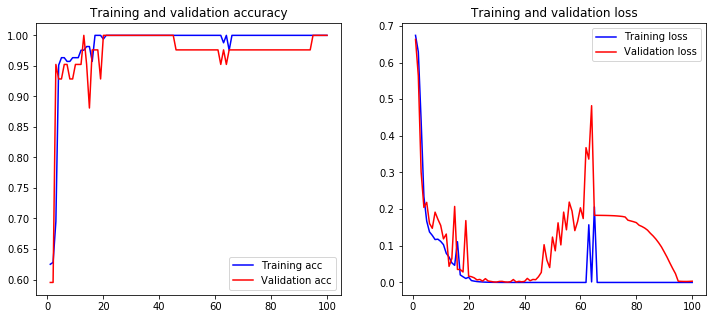

In [43]:
plot_history(hist)

In [44]:
def predictions(text):
    clean = re.sub(r'[^ a-z A-Z 0-9]', " ", text)
    test_word = word_tokenize(clean)
    test_word = [w.lower() for w in test_word]
    test_ls = word_tokenizer.texts_to_sequences(test_word)
    
    #Check for unknown words
    if [] in test_ls:
        test_ls = list(filter(None, test_ls))
    
    test_ls = np.array(test_ls).reshape(1, len(test_ls))
 
    x = padding_doc(test_ls, max_length)
  
    pred = model_cnn.predict_proba(x)
    return pred

In [45]:
def get_final_output(pred, classes):
    print(pred)
    predictions = pred[0]
    classes = np.array(classes)
    ids = np.argsort(-predictions)
    classes = classes[ids]
    predictions = -np.sort(-predictions)
    for i in range(pred.shape[1]):
        print("%s has confidence = %s" %(classes[i], (predictions[i])))

In [46]:
text = "when comes the next train from garching to odeonsplatz?"
pred = predictions(text)
get_final_output(pred, unique_intent)

[[9.9973267e-01 2.6249848e-04]]
DepartureTime has confidence = 0.9997327
FindConnection has confidence = 0.00026249848
